In [1]:
from SimPEG import Mesh, Utils, EM, Maps, Survey
from SimPEG import DataMisfit, Regularization, Optimization
from SimPEG import Directives, InvProblem, Inversion
import numpy as np
from SimPEG.PF import BaseMag, Magnetics
from scipy.constants import mu_0
from SimPEG.PF.MagAnalytics import spheremodel, CongruousMagBC
from SimPEG.PF.Magnetics import Problem3D_DiffSecondary
from pymatsolver import PardisoSolver
import matplotlib.pyplot as plt
# import SeogiUtils as SeUtils
# import simpegEM.Utils.Solver.Mumps as Mumps
# %pylab inline

# Mag Inversion

## Step1: Generating mesh

In [2]:
cs = 25.
hxind = [(cs,5,-1.3), (cs, 31),(cs,5,1.3)]
hyind = [(cs,5,-1.3), (cs, 31),(cs,5,1.3)]
hzind = [(cs,5,-1.3), (cs, 30),(cs,5,1.3)]
mesh = Mesh.TensorMesh([hxind, hyind, hzind], 'CCC')

## Step2: Generating Model: Use Combo model

### Here we combined $\mu$ model$^1$, Depth model$^2$ and Active model$^3$

In [3]:
chibkg = 1e-5
chiblk = 0.1
chi = np.ones(mesh.nC)*chibkg
sph_ind = spheremodel(mesh, 0., 0., -150., 80)
chi[sph_ind] = chiblk
active = mesh.gridCC[:,2]<0
actMap = Maps.InjectActiveCells(mesh, active, chibkg)
# dweight = np.ones(mesh.nC)
# dweight[active] = (1/abs(mesh.gridCC[active, 2]-13.)**1.5)
baseMap = BaseMag.BaseMagMap(mesh)
# depthMap = BaseMag.WeightMap(mesh, dweight)
dmap = baseMap*actMap

nC = int(np.sum(active))
idenMap = Maps.IdentityMap(nP=nC)
# rmap = depthMap*actMap
model = (chi)[active]

In [4]:
sph_ind_ini = spheremodel(mesh, 0., 0., -200., 150)

In [5]:
chi_ini = np.ones_like(chi)*chibkg
chi_ini[sph_ind_ini] = chiblk*0.1

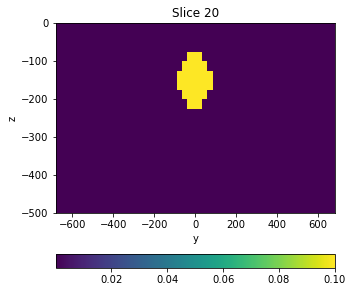

In [6]:
fig, ax = plt.subplots(1,1, figsize = (5, 5))
dat1 = mesh.plotSlice(chi, ax = ax, normal = 'X')
plt.colorbar(dat1[0], orientation="horizontal", ax = ax)
ax.set_ylim(-500, 0)
plt.show()

## Step3: Generating Data

In [7]:
survey = BaseMag.BaseMagSurvey()
const = 20
Inc = 90.
Dec = 0.
Btot = 51000
survey.setBackgroundField(Inc, Dec, Btot)




In [8]:
xr = np.linspace(-300, 300, 81)
yr = np.linspace(-300, 300, 81)
X, Y = np.meshgrid(xr, yr)
Z = np.ones((xr.size, yr.size))*(0.)
rxLoc = np.c_[Utils.mkvc(X), Utils.mkvc(Y), Utils.mkvc(Z)]
survey.rxLoc = rxLoc


prob = Problem3D_DiffSecondary(mesh, muMap = dmap)
prob.Solver = PardisoSolver
prob.pair(survey)

rxLoc = BaseMag.RxObs(rxLoc)
srcField = BaseMag.SrcField([rxLoc], param=(Btot, Inc, Dec))
survey_int = BaseMag.LinearSurvey(srcField)

In [9]:
dtrue = survey.dpred(model)

In [10]:
survey.dtrue = Utils.mkvc(dtrue)
std = 5
noise = std*np.random.randn(*survey.dtrue.shape)
survey.dobs = survey.dtrue+noise
survey.std = survey.dobs*0 + std

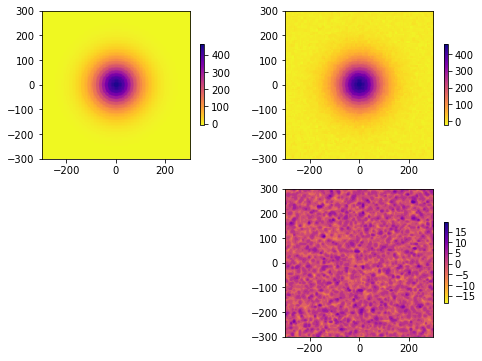

In [11]:
fig = plt.figure(figsize=(8,6))
ax1 = plt.subplot(2,2,2)
Magnetics.plot_obs_2D(survey.rxLoc, d=survey.dobs, ax=ax1, markers=False)

ax2 = plt.subplot(2,2,1)
Magnetics.plot_obs_2D(survey.rxLoc, d=dtrue, ax=ax2, markers=False)

ax3 = plt.subplot(2,2,4)
Magnetics.plot_obs_2D(survey.rxLoc, d=survey.dobs-dtrue, ax=ax3, markers=False)

plt.show()

In [12]:
# m0 = (1e-5*np.ones(mesh.nC))[active]
# m0 = chi_ini[active]/dweight[active] 
# dmisfit = DataMisfit.l2_DataMisfit(survey)
# valmin = abs(survey.dobs).max()
# dmisfit.W = 1/(np.ones(survey.dobs.size)*valmin)
mref = np.ones_like(model) * 0
m0 = np.ones_like(model) * 1e-3

dmisfit = DataMisfit.l2_DataMisfit(survey)
dmisfit.W = 1./survey.std
reg = Regularization.Sparse(mesh, indActive=active, mapping=idenMap)
reg.norms = [2,2,2,2]
reg.mref = mref
reg.eps_p = 1e-1
reg.eps_q = 1e-3



SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||


In [13]:
# Calculate distance weighting
wr = Magnetics.get_dist_wgt(mesh, survey.rxLoc, active, 3, 1)
# prob_int = Magnetics.MagneticIntegral(mesh, chiMap=idenMap, actInd=active)
# prob_int.pair(survey_int)
# wr = np.sum((prob_int.F)**2.,axis=0)

Begin calculation of distance weighting for R= 3
Done 0.0 %
Done 10.0 %
Done 20.0 %
Done 30.0 %
Done 40.0 %
Done 50.0 %
Done 60.0 %
Done 70.0 %
Done 80.0 %
Done 90.0 %
Done 100% ...distance weighting completed!!



In [14]:
# Estimate JtJ and compare with wr
m = m0
k = 20
if k is None:
    k = int(survey.nD/10)

def JtJv(v):

    Jv = prob.Jvec(m, v)

    return prob.Jtvec(m, Jv)

JtJdiag = Utils.diagEst(JtJv, len(m), k=k,approach='PROBING' )
# JtJdiag = JtJdiag / max(JtJdiag)
          

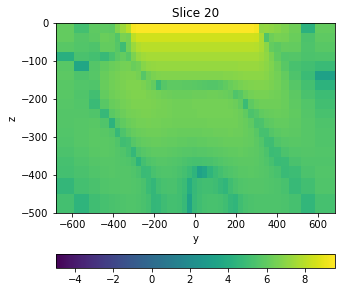

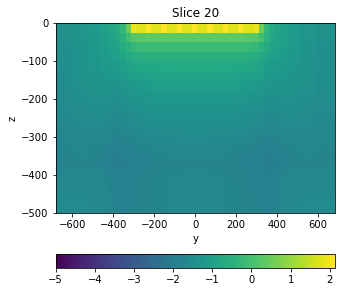

In [15]:
fig, ax = plt.subplots(1,1, figsize = (5, 5))
dat1 = mesh.plotSlice(np.log10(actMap*np.abs(JtJdiag)), ax = ax, normal = 'X')
plt.colorbar(dat1[0], orientation="horizontal", ax = ax)
ax.set_ylim(-500, 0)

fig, ax = plt.subplots(1,1, figsize = (5, 5))
dat1 = mesh.plotSlice(np.log10(actMap*wr), ax = ax, normal = 'X')
plt.colorbar(dat1[0], orientation="horizontal", ax = ax)
ax.set_ylim(-500, 0)
plt.show()

In [25]:
beta = 1e+1

reg.cell_weights = wr#(np.abs(JtJdiag)/np.abs(JtJdiag).max())**0.5
# opt = Optimization.InexactGaussNewton(maxIter = 15)
opt = Optimization.ProjectedGNCG(maxIter=20, lower=0., upper=10.,
                                 maxIterLS=20, maxIterCG=10, tolCG=1e-4)


opt.JtJdiag = np.abs(wr)

invProb = InvProblem.BaseInvProblem(dmisfit, reg, opt, beta=beta)
# Create an inversion object
# beta = Directives.BetaSchedule(coolingFactor=2, coolingRate=2)
# betaest = Directives.BetaEstimate_ByEig(beta0_ratio=1e0)
# save = Directives.SaveOutputEveryIteration()
target = Directives.TargetMisfit()
update_IRLS = Directives.Update_IRLS(f_min_change=1e-3, minGNiter=2, maxIRLSiter=10)
updateWr = Directives.Update_Wr()

inv = Inversion.BaseInversion(invProb, directiveList=[update_IRLS, updateWr])
opt.remember('xc')


C:\Users\DominiqueFournier\Documents\GIT\SimPEG\SimPEG\Directives.py:643: UserWarning: Without a Linear preconditioner, convergence may be slow. Consider adding `Directives.Update_lin_PreCond` to your directives list
  "Without a Linear preconditioner, convergence may be slow. "


In [26]:
mopt = inv.run(m0)


        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
        ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.00e+01  8.59e+05  2.00e-02  8.59e+05    1.54e+03      0              
   1  5.00e+00  6.28e+04  2.71e-01  6.28e+04    1.21e+03      0              
   2  2.50e+00  3.45e+04  2.61e-01  3.45e+04    1.44e+03      0   Skip BFGS  
   3  1.25e+00  3.40e+04  2.73e-01  3.40e+04    1.36e+03      4              
   4  6.25e-01  2.92e+04  1.87e-01  2.92e+04    1.17e+03      1   Skip BFGS  
------------------------------------------------------------------
0 :    ft     = 2.9199e+04 <= alp*descent     = 2.9161e+04
1 : maxIterLS =      20    <= iterLS          =     20
---------

In [27]:
xc = opt.recall('xc')

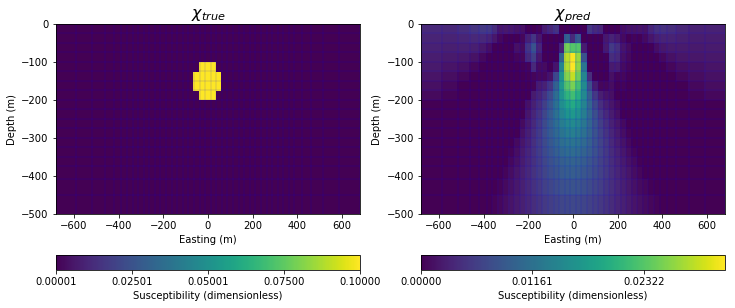

In [28]:
mout = invProb.model#np.log10(reg.cell_weights)
iteration = -1
fig = plt.figure(figsize = (12, 5))
axs = plt.subplot(1,2,1)
# normal, indx, ylim = 'Z', 17, [-500,500]
normal, indx, ylim = 'X', 18, [-500,0]

vmin = chi.min()
vmax = chi.max()
ps1 = mesh.plotSlice(chi, vType='CC', ind=indx, normal=normal, ax = axs, grid=True, gridOpts={'color':'b','lw':0.3, 'alpha':0.5});
axs.set_title('$\chi_{true}$', fontsize = 16)
axs.set_ylim(ylim)
cb1 = plt.colorbar(ps1[0], ax =  axs, orientation="horizontal", ticks=[np.linspace(vmin, vmax, 5)])
axs.set_xlabel('Easting (m)')
axs.set_ylabel('Depth (m)')

axs = plt.subplot(1,2,2)
vmin = (actMap*mout).min()
vmax = (actMap*mout).max()
ps2 = mesh.plotSlice(actMap*xc[iteration], vType='CC', ind=indx, normal=normal, ax = axs, grid=True, gridOpts={'color':'b','lw':0.3, 'alpha':0.5});
axs.set_title('$\chi_{pred}$', fontsize = 16)
axs.set_ylim(ylim)
cb2 = plt.colorbar(ps2[0], ax =  axs, orientation="horizontal", ticks=[np.linspace(vmin, vmax, 5)])
cb1.set_label('Susceptibility (dimensionless)')
cb2.set_label('Susceptibility (dimensionless)')
axs.set_xlabel('Easting (m)')
axs.set_ylabel('Depth (m)')

plt.show()
fig.savefig('model.png', dpi = 200)

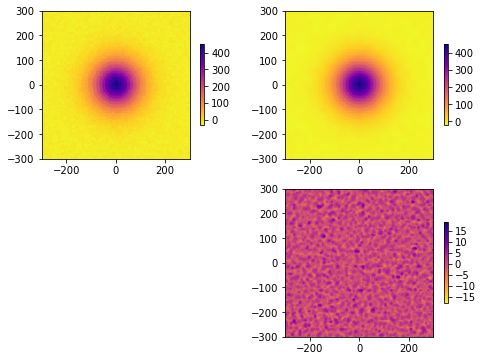

In [19]:
fig = plt.figure(figsize=(8,6))
ax1 = plt.subplot(2,2,1)
Magnetics.plot_obs_2D(survey.rxLoc, d=survey.dobs, ax=ax1, markers=False)

ax2 = plt.subplot(2,2,2)
Magnetics.plot_obs_2D(survey.rxLoc, d=invProb.dpred, ax=ax2, markers=False)

ax3 = plt.subplot(2,2,4)
Magnetics.plot_obs_2D(survey.rxLoc, d=survey.dobs-invProb.dpred, ax=ax3, markers=False)

plt.show()